## Algorytmy ewolucyjne - Lista 3
Wiktor Adamski

In [11]:
from tqdm import tnrange, tqdm_notebook, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [12]:
def griewank(v): # min @ 0*
    return 1 + np.sum((v**2)/4000) - np.prod(np.cos(v/np.sqrt(np.arange(1, v.size + 1))))

In [13]:
def rastrigin(v): # min @ 0*
    return 10*v.size + np.sum(v**2 - 10*np.cos(2*np.pi*v))

In [14]:
def schwefel(v): # min @ 420.9687*
    return 418.9829*v.size -np.sum(v*np.sin(np.sqrt(np.abs(v))))

In [15]:
def levy(v): # min @ 1*
    w = 1 + (v - 1)/4
    return np.sin(np.pi*w[0])**2 + (w[v.size - 1] - 1)**2 * (1 + (np.sin(2*np.pi*w[v.size - 1]))**2) + np.sum((w[1:-1] - 1)**2 * (1 + 10*(np.sin(np.pi * w[1:-1] + 1)**2)))

In [16]:
def powell(v): # v.size % 4 == 0 # min @ 0*
    v0 = v[::4]
    v1 = v[1::4]
    v2 = v[2::4]
    v3 = v[3::4]
    return np.sum((v0 + 10*v1)**2 + 5*(v2 - v3)**2 + (v1 - 2*v2)**4 + 10*(v0 - v3)**4)

In [17]:
def evaluate(function, genome_length, population):
    return np.apply_along_axis(function, 1, population[:,  :genome_length])

def initial_population(population_size, genome_length, mi, ma):
    xs = np.random.uniform(mi, ma, (population_size, genome_length))
    
    sigmas = np.full((population_size, genome_length), 1)
    #sigmas = np.random.uniform(-1,1, (population_size, genome_length))
    return np.hstack([xs, sigmas])

def offspring(population, population_size, genome_length, fitness, offspring_count, crossover_propability):
    offs = np.zeros((offspring_count, genome_length*2))
    for i in xrange(offspring_count/2):
        parents = parent_selection(population, population_size, fitness)
        if np.random.rand() <= crossover_propability:
            (offs[2*i], offs[2*i + 1]) = crossover(parents[0], parents[1], genome_length)
        else:
            (offs[2*i], offs[2*i + 1]) = parents
    return offs

def crossover(p1, p2, genome_length):
    o1 = p1.copy()
    o2 = p2.copy()
    cx_point = np.random.randint(0, genome_length)
    o1[cx_point:genome_length] = p2[cx_point:genome_length]
    o2[cx_point:genome_length] = p1[cx_point:genome_length]
    o1[genome_length + cx_point:] = p2[genome_length + cx_point]
    o2[genome_length + cx_point:] = p1[genome_length + cx_point]
    return (o1, o2)

def parent_selection(population, population_size, fitness):
    candidatesInd = np.random.randint(0, population_size, 10)
    (srt, srt_ev) = replace_population(population[candidatesInd], fitness[candidatesInd], 2)
    return srt

def mutation(genome, genome_length, tau, tau0):
    eps = np.random.normal(0, tau, genome_length)
    eps0 = np.random.normal(0, tau0)
    genome[genome_length:] *= np.exp(eps + eps0)
    genome[:genome_length] += np.random.normal(0, genome[genome_length:]**2)
    return genome
    
def replace_population(population, evaluation, population_size):
    ev_indices = np.argsort(evaluation)
    sorted_population = population[ev_indices]
    sorted_eval = evaluation[ev_indices]
    return (sorted_population[:population_size], sorted_eval[:population_size])

def ES(population_size,
       offspring_count,
       genome_length,
       no_of_rounds,
       evaluation_function,
       crossover_propability,
       tau_squared, tau0_squared,
       mi = -100, ma = -100):
    P = initial_population(population_size, genome_length, mi, ma)
    ev = evaluate(evaluation_function, genome_length, P)
    best_scores = np.zeros(no_of_rounds)
    
    for round_no in tqdm_notebook(xrange(no_of_rounds), leave = False):
        Pc = offspring(P, population_size, genome_length, ev, offspring_count, crossover_propability)
        Pc = np.apply_along_axis(mutation, 1, Pc, genome_length, tau_squared, tau0_squared)
        ev = evaluate(evaluation_function, genome_length, Pc)
        (P, ev) = replace_population(Pc, ev, population_size)
        best_scores[round_no] = ev[0]
    return best_scores

def ESplus(population_size,
       offspring_count,
       genome_length,
       no_of_rounds,
       evaluation_function,
       crossover_propability,
       tau_squared, tau0_squared,
       mi = -100, ma = -100):
    P = initial_population(population_size, genome_length, mi, ma)
    ev = evaluate(evaluation_function, genome_length, P)
    best_scores = np.zeros(no_of_rounds)
    
    for round_no in tqdm_notebook(xrange(no_of_rounds), leave = False):
        Pc = offspring(P, population_size, genome_length, ev, offspring_count, crossover_propability)
        Pc = np.apply_along_axis(mutation, 1, np.vstack([P, Pc]), genome_length, tau_squared, tau0_squared)
        ev = evaluate(evaluation_function, genome_length, Pc)
        (P, ev) = replace_population(Pc, ev, population_size)
        best_scores[round_no] = ev[0]
    return best_scores

In [18]:
def sim_ann(T = 500000,
        radius = 1,
        alpha = 1.0,
        objective = griewank,
        genome_length = 100,
        mi = -100, ma = 100):
    p = np.random.uniform(mi, ma, genome_length)
    p_cost = objective(p)
    costs = np.zeros(T)
    for t in tqdm_notebook(xrange(T), leave = False):
        q = p + np.random.uniform(-radius, radius, genome_length)
        q_cost = objective(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return costs

## Griewank function

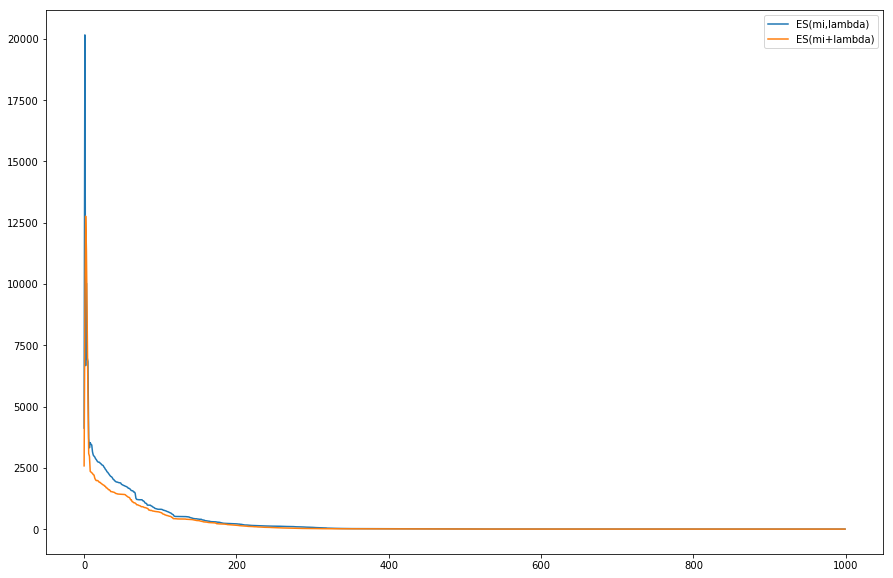

0.0656713295987 0.070903451214


In [60]:
e = ES(100, 200, 100, 1000, griewank, 0.75, 3, 0.7, -600, 600)
ep = ESplus(100, 200, 100, 1000, griewank, 0.75, 3, 0.7, -600, 600)

plt.figure(figsize=(15,10))
plt.plot(e, label='ES(mi,lambda)')
plt.plot(ep, label='ES(mi+lambda)')
plt.legend()
plt.show()
print e.min(), ep.min()

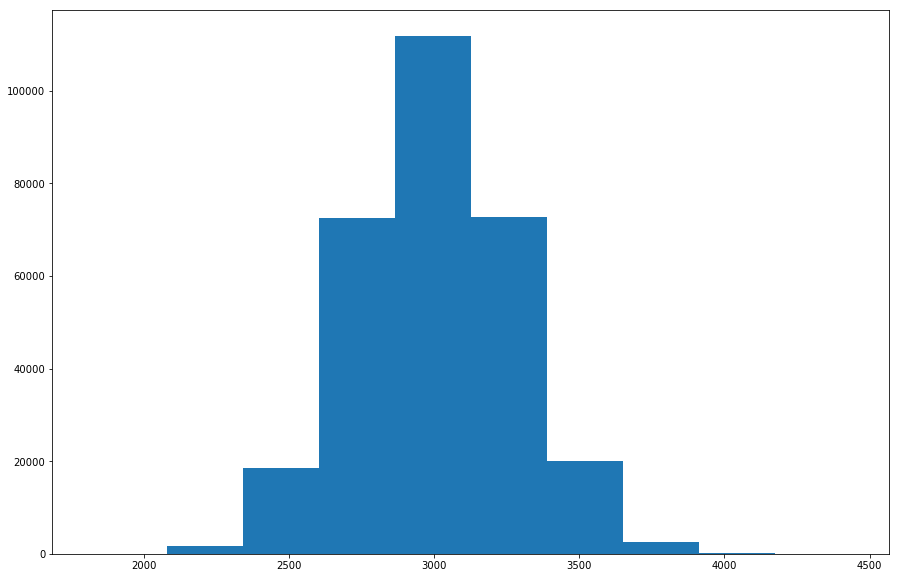

In [61]:
no_of_probes = (300 * 1000)
random_sampling = np.zeros(no_of_probes)

for i in tqdm_notebook(xrange(no_of_probes)):
    random_sampling[i] = griewank(np.random.uniform(-600, 600, 100))

plt.figure(figsize=(15, 10))
plt.hist(random_sampling)
plt.show()

In [ ]:
e = np.zeros(100)
ep = np.zeros(100)
sim = np.zeros(100)


for round_no in tqdm_notebook(xrange(100)):
    e[round_no] = ES(100, 200, 100, 1000, griewank, 0.75, 2, 0.7, -600, 600).min()
    ep[round_no] = ESplus(100, 200, 100, 1000, griewank, 0.75, 2, 0.7, -600, 600).min()
    sim[round_no] = sim_ann(300*1000, 5, 1.0, griewank, 100, -600, 600).min()
    
plt.figure(figsize=(15,10))
plt.hist(ep, label='ES(mi+lambda)')
plt.hist(e, label='ES(mi,lambda)')
plt.hist(sim, label='Simulated annealing')
plt.legend()
plt.show()
print e.min(), ep.min(), sim.min()

## Rastrigin function

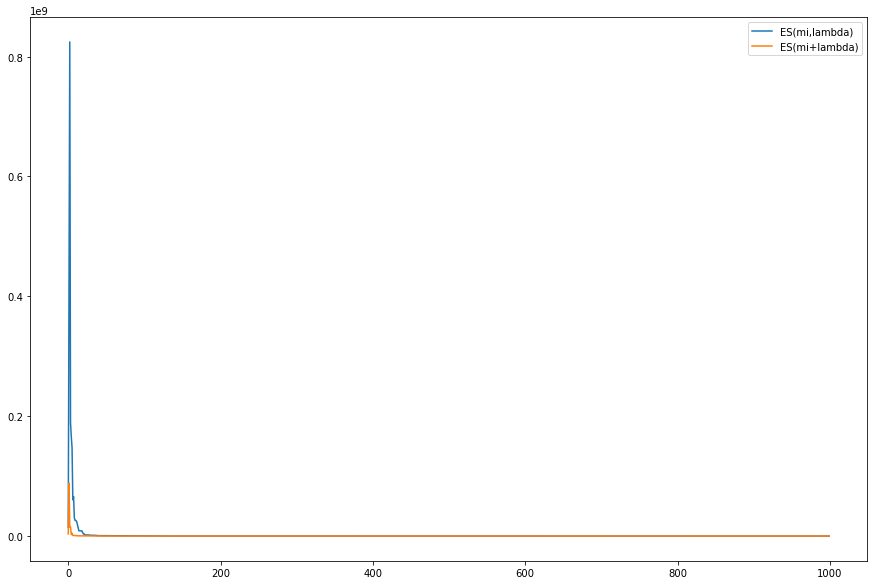

147.645500168 47.0720621639


In [62]:
e = ES(100, 200, 100, 1000, rastrigin, 0.75, 3, 0.7, -5.12, 5.12)
ep = ESplus(100, 200, 100, 1000, rastrigin, 0.75, 3, 0.7, -5.12, 5.12)

plt.figure(figsize=(15,10))
plt.plot(e, label='ES(mi,lambda)')
plt.plot(ep, label='ES(mi+lambda)')
plt.legend()
plt.show()
print e.min(), ep.min()

In [ ]:
e = np.zeros(100)
ep = np.zeros(100)
sim = np.zeros(100)

for round_no in tqdm_notebook(xrange(100)):
    e[round_no] = ES(100, 200, 100, 1000, rastrigin, 0.75, 2, 0.7, -5.12, 5.12).min()
    ep[round_no] = ESplus(100, 200, 100, 1000, rastrigin, 0.75, 2, 0.7, -5.12, 5.12).min()
    sim[round_no] = sim_ann(300*1000, 5, 1.0, rastrigin, 100, -5.12, 5.12).min()
    
plt.figure(figsize=(15,10))
plt.hist(ep, label='ES(mi+lambda)')
plt.hist(e, label='ES(mi,lambda)')
plt.hist(sim, label='Simulated annealing')
plt.legend()
plt.show()
print e.min(), ep.min(), sim.min()

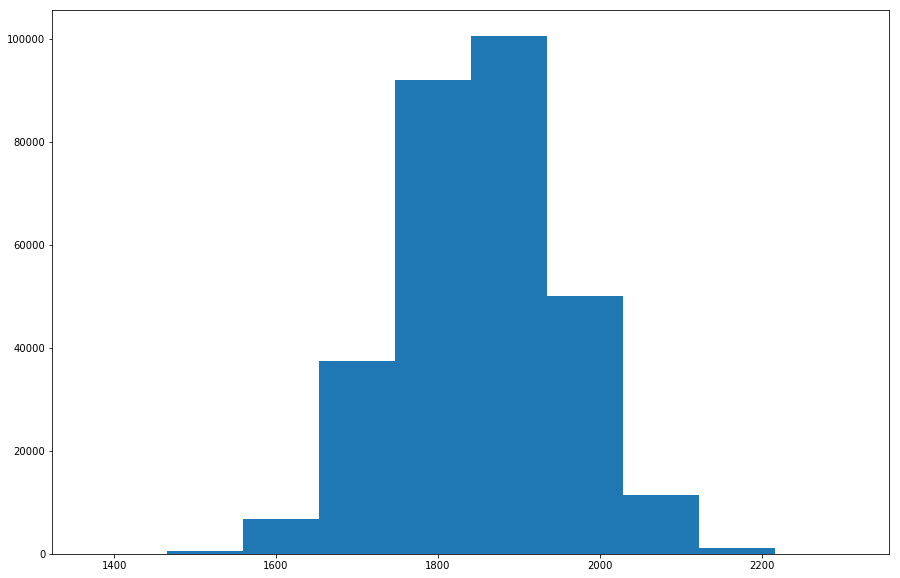

In [63]:
no_of_probes = (300 * 1000)
random_sampling = np.zeros(no_of_probes)

for i in tqdm_notebook(xrange(no_of_probes)):
    random_sampling[i] = rastrigin(np.random.uniform(-5.12, 5.12, 100))

plt.figure(figsize=(15, 10))
plt.hist(random_sampling)
plt.show()

## Schwefel function

/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square
/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sin
  


/pio/os/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2324: RuntimeWarning: overflow encountered in double_scalars
  x0t -= delta


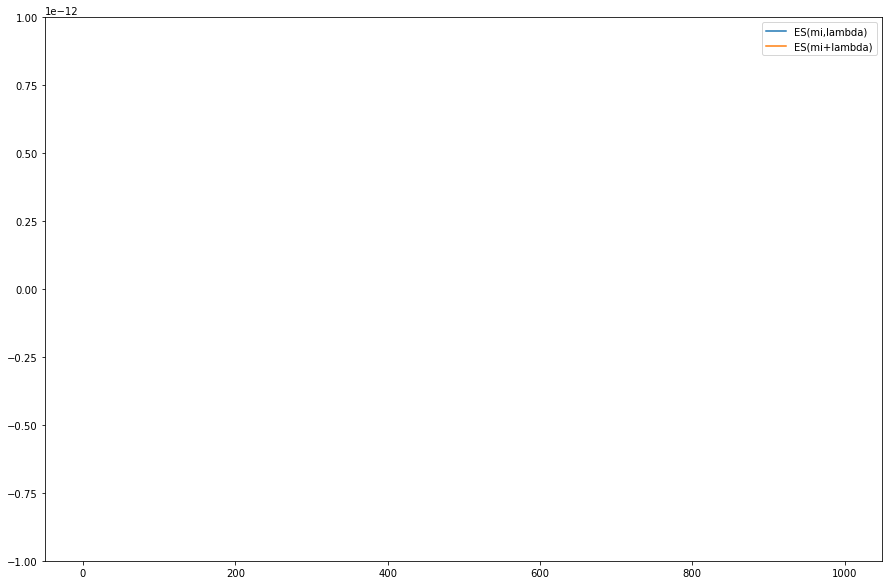

-1.55678855542e+264 -1.76019334466e+308


In [71]:
e = ES(100, 200, 100, 1000, schwefel, 0.75, 3, 0.7, -500, 500)
ep = ESplus(100, 200, 100, 1000, schwefel, 0.75, 3, 0.7, -500, 500)

plt.figure(figsize=(15,10))
plt.plot(e, label='ES(mi,lambda)')
plt.plot(ep, label='ES(mi+lambda)')
plt.legend()
plt.show()
print e.min(), ep.min()

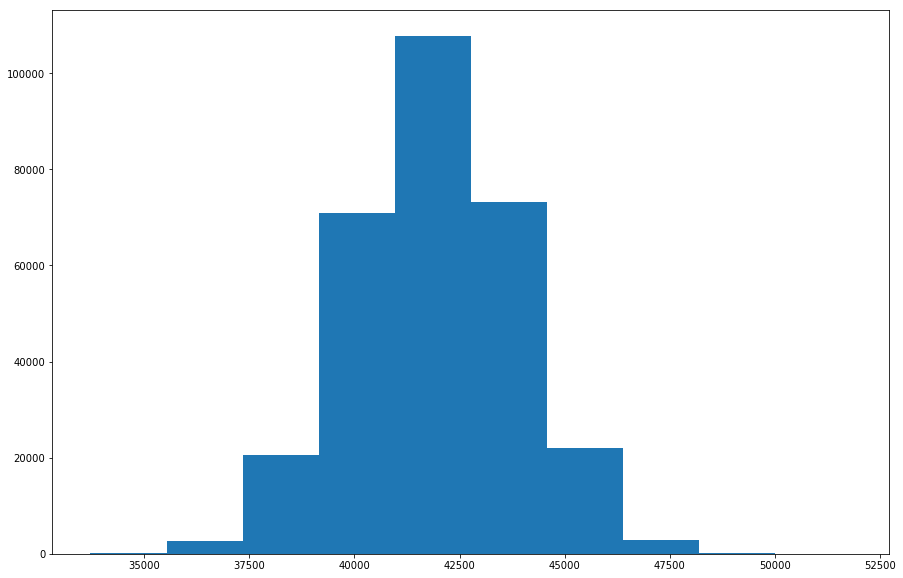

In [70]:
no_of_probes = (300 * 1000)
random_sampling = np.zeros(no_of_probes)

for i in tqdm_notebook(xrange(no_of_probes)):
    random_sampling[i] = schwefel(np.random.uniform(-500, 500, 100))

plt.figure(figsize=(15, 10))
plt.hist(random_sampling)
plt.show()

## Levy function

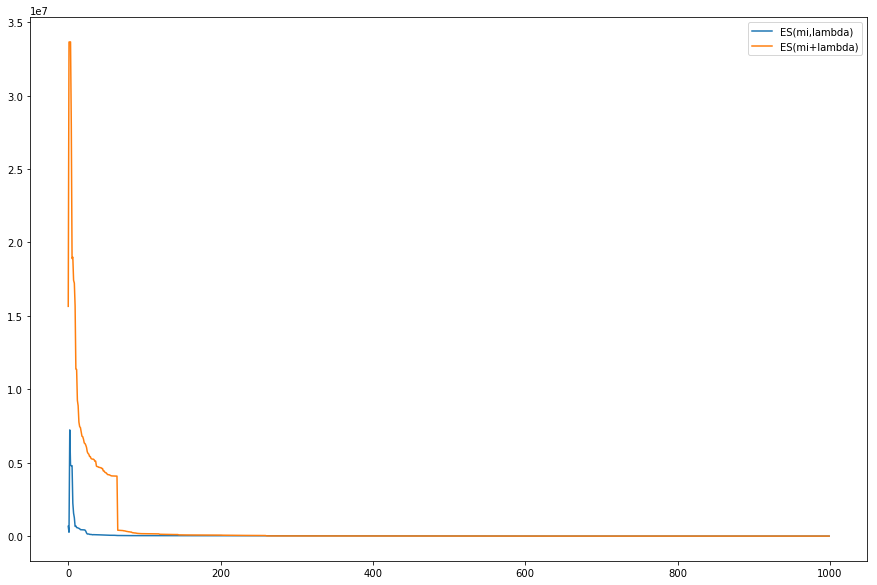

1.70151150825 1.30364985003


In [67]:
e = ES(100, 200, 100, 1000, levy, 0.75, 3, 0.7, -10, 10)
ep = ESplus(100, 200, 100, 1000, levy, 0.75, 3, 0.7, -10, 10)

plt.figure(figsize=(15,10))
plt.plot(e, label='ES(mi,lambda)')
plt.plot(ep, label='ES(mi+lambda)')
plt.legend()
plt.show()
print e.min(), ep.min()

In [ ]:
e = np.zeros(100)
ep = np.zeros(100)
sim = np.zeros(100)

for round_no in tqdm_notebook(xrange(100)):
    e[round_no] = ES(100, 200, 100, 1000, levy, 0.75, 2, 0.7, -10, 10).min()
    ep[round_no] = ESplus(100, 200, 100, 1000, levy, 0.75, 2, 0.7, -10, 10).min()
    sim[round_no] = sim_ann(300*1000, 5, 1.0, levy, 100, -10, 10).min()
    
plt.figure(figsize=(15,10))
plt.hist(ep, label='ES(mi+lambda)')
plt.hist(e, label='ES(mi,lambda)')
plt.hist(sim, label='Simulated annealing')
plt.legend()
plt.show()
print e.min(), ep.min(), sim.min()

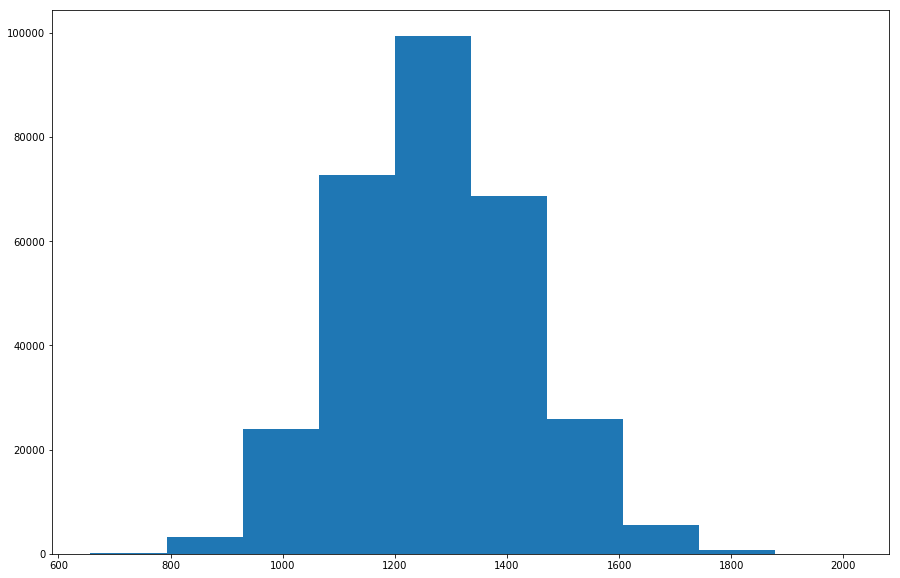

In [66]:
no_of_probes = (300 * 1000)
random_sampling = np.zeros(no_of_probes)

for i in tqdm_notebook(xrange(no_of_probes)):
    random_sampling[i] = levy(np.random.uniform(-10, 10, 100))

plt.figure(figsize=(15, 10))
plt.hist(random_sampling)
plt.show()

## Powell function

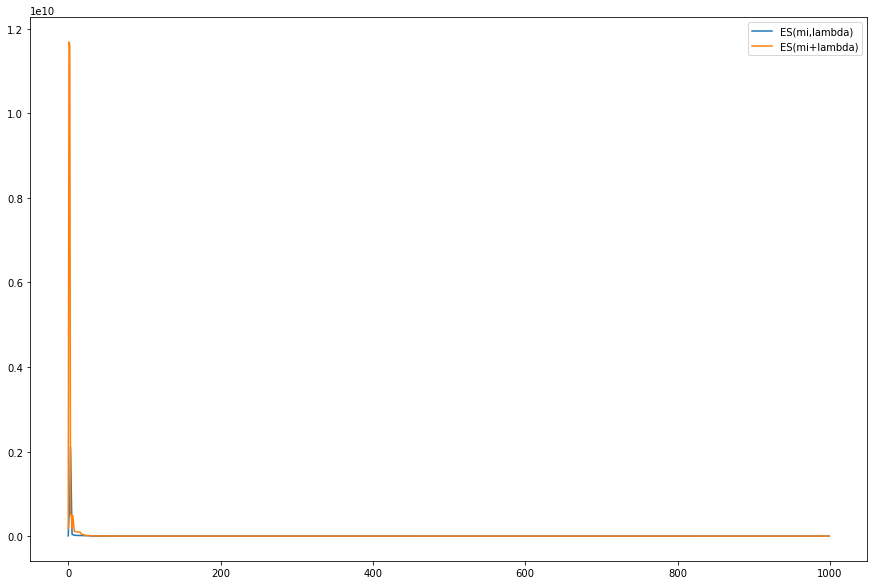

159.565764374 4514.21835519


In [68]:
e = ES(100, 200, 100, 1000, powell, 0.75, 2, 0.7, -4, 5)
ep = ESplus(100, 200, 100, 1000, powell, 0.75, 2, 0.7, -4, 5)

plt.figure(figsize=(15,10))
plt.plot(e, label='ES(mi,lambda)')
plt.plot(ep, label='ES(mi+lambda)')
plt.legend()
plt.show()
print e.min(), ep.min()

In [ ]:
e = np.zeros(100)
ep = np.zeros(100)
sim = np.zeros(100)

for round_no in tqdm_notebook(xrange(100)):
    e[round_no] = ES(100, 200, 100, 1000, powell, 0.75, 2, 0.7, -4, 5).min()
    ep[round_no] = ESplus(100, 200, 100, 1000, powell, 0.75, 2, 0.7, -4, 5).min()
    sim[round_no] = sim_ann(300*1000, 5, 1.0, powell, 100, -4, 5).min()
    
plt.figure(figsize=(15,10))
plt.hist(ep, label='ES(mi+lambda)')
plt.hist(e, label='ES(mi,lambda)')
plt.hist(sim, label='Simulated annealing')
plt.legend()
plt.show()
print e.min(), ep.min(), sim.min()

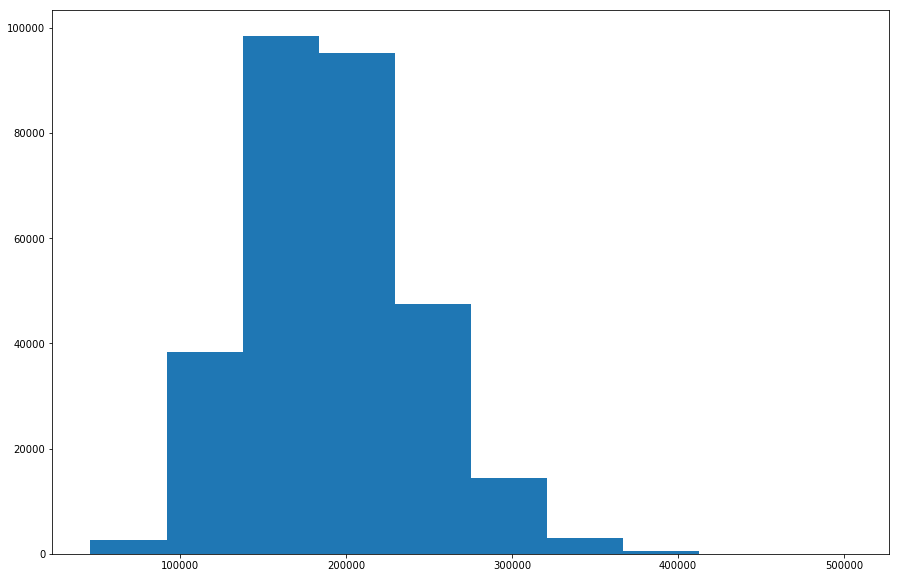

46195.310534


In [59]:
no_of_probes = (300 * 1000)
random_sampling = np.zeros(no_of_probes)

for i in tqdm_notebook(xrange(no_of_probes)):
    random_sampling[i] = powell(np.random.uniform(-4, 5, 100))

plt.figure(figsize=(15, 10))
plt.hist(random_sampling)
plt.show()
print random_sampling.min()